In [1]:
from pyspark.sql.types import *
import pandas as pd
import pyspark 
import os 
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, udf, rank, asc, sum as spark_sum
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


In [2]:
# Start a Spark session
spark = SparkSession.builder.appName("s33ding").getOrCreate()

# Read the Parquet file into a DataFrame
df = spark.read.parquet("dataset/enem.parquet")
# Select the relevant columns
selected_cols = ["NOTA_CH_CIENCIAS_HUMANAS", "NOTA_LC_LINGUAGENS_E_CODIGOS", "NOTA_MT_MATEMATICA", "NOTA_REDACAO","NOTA_CN_CIENCIAS_DA_NATUREZA"]
df_selected = df.select(selected_cols)
df_selected.show(3)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/17 13:29:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------------------------+----------------------------+------------------+------------+----------------------------+
|NOTA_CH_CIENCIAS_HUMANAS|NOTA_LC_LINGUAGENS_E_CODIGOS|NOTA_MT_MATEMATICA|NOTA_REDACAO|NOTA_CN_CIENCIAS_DA_NATUREZA|
+------------------------+----------------------------+------------------+------------+----------------------------+
|                   478.4|                       426.8|             351.2|       380.0|                       411.3|
|                   459.3|                       571.7|             467.0|       900.0|                       440.0|
|                   435.7|                       568.2|             414.7|       960.0|                       607.1|
+------------------------+----------------------------+------------------+------------+----------------------------+
only showing top 3 rows



In [3]:
from pyspark.sql.functions import monotonically_increasing_id

# Split the dataset into training, validation, and testing sets
train_data, validation_data, test_data = df_selected.randomSplit([0.6, 0.2, 0.2], seed=42)

# Prepare the feature vector and the target column for the training, validation, and testing sets
assembler = VectorAssembler(inputCols=["NOTA_LC_LINGUAGENS_E_CODIGOS", "NOTA_MT_MATEMATICA", "NOTA_REDACAO"], outputCol="features")

# Transform the training data and add a primary key column
train_data = assembler.transform(train_data).select("features", "NOTA_CN_CIENCIAS_DA_NATUREZA")
train_data = train_data.withColumn("pk", monotonically_increasing_id())

# Transform the validation data and add a primary key column
validation_data = assembler.transform(validation_data).select("features", "NOTA_CN_CIENCIAS_DA_NATUREZA")
validation_data = validation_data.withColumn("pk", monotonically_increasing_id())

# Transform the testing data and add a primary key column
test_data = assembler.transform(test_data).select("features", "NOTA_CN_CIENCIAS_DA_NATUREZA")
test_data = test_data.withColumn("pk", monotonically_increasing_id())

# Train the machine learning models using the training set
# Linear Regression
lr = LinearRegression(labelCol="NOTA_CN_CIENCIAS_DA_NATUREZA")
lr_model = lr.fit(train_data)

# Decision Tree Regression
dt = DecisionTreeRegressor(labelCol="NOTA_CN_CIENCIAS_DA_NATUREZA")
dt_model = dt.fit(train_data)

# Random Forest Regression
rf = RandomForestRegressor(labelCol="NOTA_CN_CIENCIAS_DA_NATUREZA")
rf_model = rf.fit(train_data)

# Make predictions using the trained models on the validation set
lr_predictions = lr_model.transform(validation_data)
dt_predictions = dt_model.transform(validation_data)
rf_predictions = rf_model.transform(validation_data)


23/06/17 13:29:58 WARN Instrumentation: [9cd71f9a] regParam is zero, which might cause numerical instability and overfitting.
23/06/17 13:30:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/17 13:30:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/06/17 13:30:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [5]:
from pyspark.sql.functions import col

# Create temporary views for the predictions
lr_predictions.createOrReplaceTempView("lr_predictions")
dt_predictions.createOrReplaceTempView("dt_predictions")
rf_predictions.createOrReplaceTempView("rf_predictions")

# Join the predictions using the primary key (pk) column
joined_predictions = spark.sql("""
    SELECT lr_predictions.features, lr_predictions.prediction AS lr_prediction,
           dt_predictions.prediction AS dt_prediction, rf_predictions.prediction AS rf_prediction,
           lr_predictions.NOTA_CN_CIENCIAS_DA_NATUREZA
    FROM lr_predictions
    JOIN dt_predictions ON lr_predictions.pk = dt_predictions.pk
    JOIN rf_predictions ON lr_predictions.pk = rf_predictions.pk
    ORDER BY lr_predictions.pk
""")


# Get a sample from the joined_predictions DataFrame
sample_joined_predictions = joined_predictions.sample(fraction=0.1, seed=42)

# Save the sample as a Parquet file
sample_joined_predictions.write.mode('overwrite').parquet('data_for_dashboards/models/nota_ch/joined_predictions')

# Show the joined predictions
joined_predictions.show()

+--------------------+------------------+------------------+------------------+----------------------------+
|            features|     lr_prediction|     dt_prediction|     rf_prediction|NOTA_CN_CIENCIAS_DA_NATUREZA|
+--------------------+------------------+------------------+------------------+----------------------------+
| [413.0,444.0,360.0]|417.37220655944907| 420.7563143169134|427.64969385151363|                       381.8|
|[411.600006103515...| 395.7989127476043| 420.7563143169134|430.23328107677924|                       526.4|
|[338.600006103515...| 398.1544643078139| 420.7563143169134| 430.3909895100907|                       476.2|
|[327.799987792968...| 380.7994189681648|433.09694199066223| 443.2722647183342|                       519.6|
|[434.200012207031...|460.24544658291404|456.88679584389746|454.54046004585507|                       422.4|
|[345.200012207031...|380.69906920968435| 420.7563143169134| 427.2514474813123|                       321.3|
|[438.299987792968.

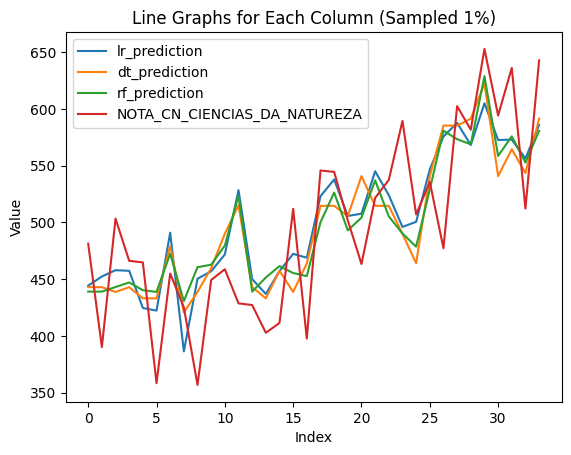

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
df = joined_predictions.sample(fraction=0.0005, seed=42).toPandas()

# Line graph for each column
for column in df.columns:
    if column != "features":
        plt.plot(df[column], label=column)

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Graphs for Each Column (Sampled 1%)')

# Show legend
plt.legend()

# Display the plot
plt.show()


In [7]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="NOTA_CN_CIENCIAS_DA_NATUREZA", predictionCol="prediction")

# Calculate MSE for linear regression
lr_mse = evaluator.evaluate(lr_predictions, {evaluator.metricName: "mse"})

# Calculate MSE for decision tree regression
dt_mse = evaluator.evaluate(dt_predictions, {evaluator.metricName: "mse"})

# Calculate MSE for random forest regression
rf_mse = evaluator.evaluate(rf_predictions, {evaluator.metricName: "mse"})

# Calculate MAE for linear regression
lr_mae = evaluator.evaluate(lr_predictions, {evaluator.metricName: "mae"})

# Calculate MAE for decision tree regression
dt_mae = evaluator.evaluate(dt_predictions, {evaluator.metricName: "mae"})

# Calculate MAE for random forest regression
rf_mae = evaluator.evaluate(rf_predictions, {evaluator.metricName: "mae"})

# Calculate MSE and MAE for each model
metrics = [("Linear Regression - MSE", lr_mse),
           ("Decision Tree Regression - MSE", dt_mse),
           ("Random Forest Regression - MSE", rf_mse),
           ("Linear Regression - MAE", lr_mae),
           ("Decision Tree Regression - MAE", dt_mae),
           ("Random Forest Regression - MAE", rf_mae)]

# Create the DataFrame with "Type" column
df_comparing_models = spark.createDataFrame(metrics, ["Model", "Metric"]).withColumn("Type", udf(lambda model: "MSE" if "MSE" in model else "MAE", StringType())("Model"))

# Create a window specification to partition by the type and order by the metric in ascending order
window_spec = Window.partitionBy("Type").orderBy(asc("Metric"))

# Add a "Best" column to determine the best model for each type
df_comparing_models = df_comparing_models.withColumn("Best", rank().over(window_spec) == 1)

# Show the DataFrame
df_comparing_models.show(truncate=False)
df_comparing_models.write.mode('overwrite').parquet('data_for_dashboards/models/nota_ch/msa_mse/')

+------------------------------+------------------+----+-----+
|Model                         |Metric            |Type|Best |
+------------------------------+------------------+----+-----+
|Random Forest Regression - MAE|42.78322750914623 |MAE |true |
|Decision Tree Regression - MAE|42.941232213088206|MAE |false|
|Linear Regression - MAE       |42.953862088704525|MAE |false|
|Random Forest Regression - MSE|2808.4029016881273|MSE |true |
|Decision Tree Regression - MSE|2863.052812785686 |MSE |false|
|Linear Regression - MSE       |2875.4783460167473|MSE |false|
+------------------------------+------------------+----+-----+



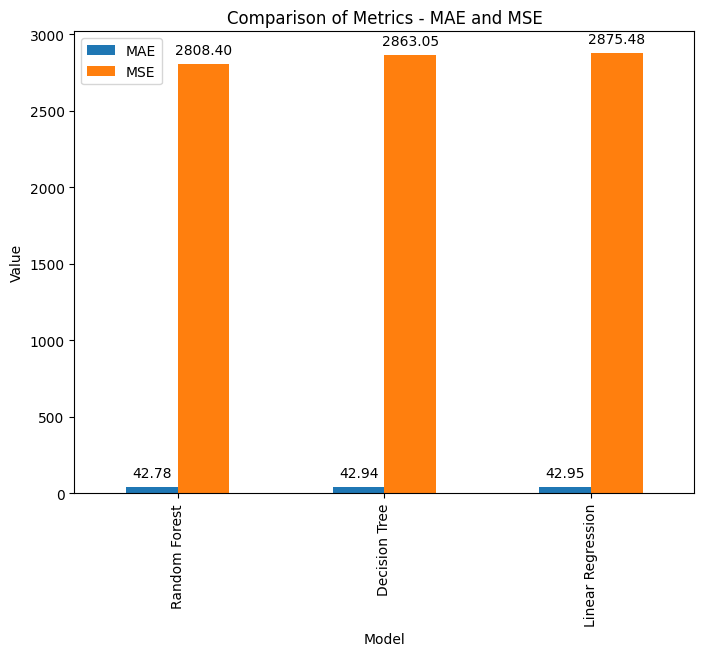

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a Pandas DataFrame with the model, MAE, and MSE values
data = {
    'Model': ['Random Forest', 'Decision Tree', 'Linear Regression'],
    'MAE': [42.78, 42.94, 42.95],
    'MSE': [2808.40, 2863.05, 2875.48]
}

# Create a bar plot
df = pd.DataFrame(data)
ax = df.plot(x='Model', y=['MAE', 'MSE'], kind='bar', figsize=(8, 6))  # Adjust the figure size here

# Set labels and title
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Comparison of Metrics - MAE and MSE')

# Add value labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Display the plot
plt.show()


In [83]:
# Specify the path to save the model
model_path = "models/nota_ch_ciencias_humanas/random_forest"

# Save the Linear Regression model
rf_model.save(model_path)